# Image Colorization


<h3>
  <strong>Giriş</strong>
</h3>

<div>
<img src="https://richzhang.github.io/colorization/resources/images/teaser3.jpg" width="500"/>
</div>


> Renklendirme, insan algısında önemli rol oynayan görsel bilgilere (siyah-beyaz fotoğraf ya da videoya), bilgisayar desteği kullanarak renk bilgisini ekleme işlemidir. Aynı zamanda, tek renkli bir görüntünün her pikselindeki parlaklık değerinin çok boyutlu renkli bir vektör ile değiştirilmesi anlamına gelir.


<h3>
  <strong>Problem Tanımı</strong>
</h3>

> Görüntü renklendirme, gri tonlamalı bir görüntüyü/videoyu estetik açıdan daha çekici ve algısal olarak daha anlamlı kılmak için renk atama işlemidir. Fotoğraf düzeyinde kalite elde etmek için genellikle görüntü içeriği hakkında önceden bilgi sahibi olmak gerekir. Oldukça karmaşık bir problemdir. 

Veri Kaynağı: https://cocodataset.org/

<h3>
  <strong>İçindekiler</strong>
</h3>

1.   [Veri Hazırlama](#cell-id1)

    1.1. [Veri Yükleyici](#cell-id1.1)

2.   [Görüntü Renklendirme Modeli](#cell-id2) 

    2.1. [Özellik Oluşturucu](#cell-id2.1)
    
    2.2. [GAN ile Renklendirici Modeli](#cell-id2.2)

3.   [Demo](#cell-id3)


[Referanslar](#cell-id5)


</table>


## 🛠 Import Modules 

In [1]:
%%capture
!pip install fastai==2.4
!pip install pytube

In [2]:
import os
import glob
import cv2
import imageio
import base64
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from fastai.data.external import untar_data, URLs
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet
from google.colab import files
from pytube import YouTube

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

import warnings
warnings.filterwarnings("ignore")

Mounted at /content/gdrive


In [4]:
generator_model_path = '/content/gdrive/MyDrive/pretrained_models/image_colorization/res18-unet.pt'
colorization_model_path = '/content/gdrive/MyDrive/pretrained_models/image_colorization/final_model_weights.pt'

<a name="cell-id1"></a>
## **1.** 📹 Prepare Dataset



In [5]:
seed = 123
fit = False
SIZE = 256 
coco_path = untar_data(URLs.COCO_SAMPLE)
coco_path = str(coco_path) + "/train_sample"
    
paths = glob.glob(coco_path + "/*.jpg") # Grabbing all the image file names
np.random.seed(seed)
paths_subset = np.random.choice(paths, 10_000, replace=False) # choosing 1000 images randomly
rand_idxs = np.random.permutation(10_000)
train_idxs = rand_idxs[:8000] # choosing the first 8000 as training set
val_idxs = rand_idxs[8000:] # choosing last 2000 as validation set
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]

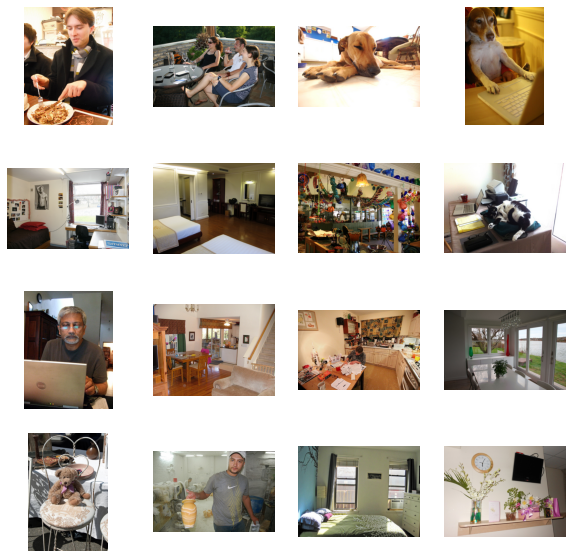

In [6]:
_, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

<a name="cell-id1.1"></a>
### Datasets & Dataloader


<div>
<img src="https://www.journaldev.com/wp-content/uploads/2020/02/PyTorch-Data-Loader.png" width="450"/>
</div>

In [7]:
class ColorizationDataset(Dataset):
    def __init__(self, paths, split='train'):
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((SIZE, SIZE),  Image.BICUBIC),
                transforms.RandomHorizontalFlip(), # A little data augmentation!
            ])
        elif split == 'val':
            self.transforms = transforms.Resize((SIZE, SIZE),  Image.BICUBIC)
        
        self.split = split
        self.size = SIZE
        self.paths = paths
    
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32") # Converting RGB to L*a*b
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 50. - 1. # Between -1 and 1
        ab = img_lab[[1, 2], ...] / 110. # Between -1 and 1
        
        return {'L': L, 'ab': ab}
    
    def __len__(self):
        return len(self.paths)

def make_dataloaders(batch_size=16, n_workers=4, pin_memory=True, **kwargs): 
    dataset = ColorizationDataset(**kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers,
                            pin_memory=pin_memory)
    return dataloader

In [8]:
train_dl = make_dataloaders(paths=train_paths, split='train')
val_dl = make_dataloaders(paths=val_paths, split='val')


<a name="cell-id2"></a>
##**2.** 🎨Image Colorization Model



<a name="cell-id2.1"></a>
###Feature Generator with Unet

<div>
<img src="https://camo.githubusercontent.com/d55a437337d0e08c6a082714959253d80b81ce4e6c18e94688d9aff16e3bf2f8/68747470733a2f2f6c6d622e696e666f726d6174696b2e756e692d66726569627572672e64652f70656f706c652f726f6e6e656265722f752d6e65742f752d6e65742d6172636869746563747572652e706e67" width="450"/>
</div>

[Ronneberger, O., Fischer, P., & Brox, T. (2015, October). U-net: Convolutional networks for biomedical image segmentation. In International Conference on Medical image computing and computer-assisted intervention (pp. 234-241). Springer, Cham.](https://https://arxiv.org/pdf/1505.04597.pdf)

<div>
<img src="https://www.researchgate.net/profile/Tobias-Ross-2/publication/321324833/figure/fig2/AS:667846015205378@1536238306185/Pretraining-using-self-supervised-learning-and-a-generative-adversarial-network-GAN.ppm" width="450"/>
</div>


In [9]:
class AverageMeter:
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3
    
    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()
    
    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

def lab_to_rgb(L, ab):
    """
    Takes a batch of images
    """
    
    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)
    
def visualize(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")
        
def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")

In [10]:
def build_res_unet(n_input=1, n_output=2, size=256):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    body = create_body(resnet18, pretrained=True, n_in=n_input, cut=-2)
    net_G = DynamicUnet(body, n_output, (size, size)).to(device)
    return net_G

In [11]:
def pretrain_generator(net_G, train_dl, opt, criterion, epochs):
    for e in range(epochs):
        loss_meter = AverageMeter()
        for data in tqdm(train_dl):
            L, ab = data['L'].to(device), data['ab'].to(device)
            preds = net_G(L)
            loss = criterion(preds, ab)
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            loss_meter.update(loss.item(), L.size(0))
            
        print(f"Epoch {e + 1}/{epochs}")
        print(f"L1 Loss: {loss_meter.avg:.5f}")

In [12]:
if fit:    
    net_G = build_res_unet(n_input=1, n_output=2, size=SIZE)
    opt = optim.Adam(net_G.parameters(), lr=1e-4)
    criterion = nn.L1Loss()        
    pretrain_generator(net_G, train_dl, opt, criterion, 20)
    #torch.save(net_G.state_dict(), "res18-unet.pt")

<a name="cell-id2.2"></a>
###GAN Colorization Model


<div>
<img src="https://miro.medium.com/max/1400/1*JnUzBXe5Zq-HT--iNKrCuQ.png" width="650"/>
</div>

In [13]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2) 
                          for i in range(n_down)] # the 'if' statement is taking care of not using
                                                  # stride of 2 for the last block in this loop
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] # Make sure to not use normalization or
                                                                                             # activation for the last layer of the model
        self.model = nn.Sequential(*model)                                                   
        
    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): # when needing to make some repeatitive blocks of layers,
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]          # it's always helpful to make a separate method for that purpose
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [14]:
class GANLoss(nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
    
    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)
    
    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

In [15]:
def init_weights(net, init='norm', gain=0.02):
    
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)
            
    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net

def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

In [16]:
class MainModel(nn.Module):
    def __init__(self, net_G, lr_G=2e-4, lr_D=2e-4, 
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1
        self.net_G = net_G.to(self.device)
        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))
    
    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad
        
    def setup_input(self, data):
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)
        
    def forward(self):
        self.fake_color = self.net_G(self.L)
    
    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()
    
    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()
    
    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()
        
        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

In [17]:
def train_model(model, train_dl, epochs, display_every=200):
    data = next(iter(val_dl)) # getting a batch for visualizing the model output after fixed intrvals
    for e in range(epochs):
        loss_meter_dict = create_loss_meters() # function returing a dictionary of objects to 
        i = 0                                  # log the losses of the complete network
        for data in tqdm(train_dl):
            model.setup_input(data) 
            model.optimize()
            update_losses(model, loss_meter_dict, count=data['L'].size(0)) # function updating the log objects
            i += 1
            if i % display_every == 0:
                print(f"\nEpoch {e+1}/{epochs}")
                print(f"Iteration {i}/{len(train_dl)}")
                log_results(loss_meter_dict) # function to print out the losses
                visualize(model, data, save=False) # function displaying the model's outputs

In [18]:
if fit:
    net_G = build_res_unet(n_input=1, n_output=2, size=256)
    net_G.load_state_dict(torch.load("res18-unet.pt", map_location=device))
    model = MainModel(net_G=net_G)
    train_model(model, train_dl, 20)

<a name="cell-id3"></a>
## **3.** 📎 Demo

model initialized with norm initialization


Saving monroe.jpg to monroe (1).jpg


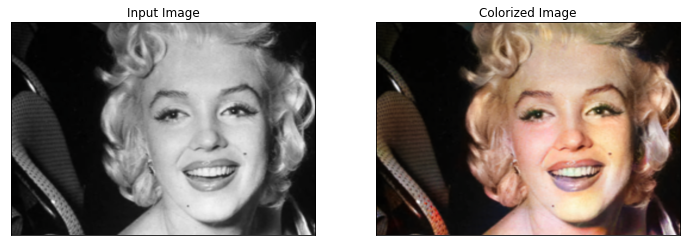

In [26]:
#@title Select the input type - Image or Video


data = "Image" #@param ["Image", "Video"]

# Load pretrained models
net_G = build_res_unet(n_input=1, n_output=2, size=256)
net_G.load_state_dict(torch.load(generator_model_path, map_location=device))
model = MainModel(net_G=net_G)
model.load_state_dict(torch.load(colorization_model_path, map_location=device))
# Model load complete!

def visualize(save=True, **images):
    """
    PLot images in one row.
    Parameters
    ----------
    **images : ndarray
        Images sent for plotting.
        input image, ground_truth, generated_mask
    """
    n = len(images)
    plt.figure(figsize=(12, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([]) 
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    if save:
        plt.savefig(f"output.png")
    plt.show()
    

def load_video(input_loc):
    frames = []
    cap = cv2.VideoCapture(input_loc)
    video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) - 1
    print ("Frame num: ", video_length)
    count = 0
    print ("Extracting frames..\n")
    while cap.isOpened():
        ret, frame = cap.read()
        data, shape = prep_data(img=Image.fromarray(frame))
        fake_imgs, real_imgs = predict(model, data)
        frame = cv2.resize(fake_imgs[0], shape)
        frame = cv2.resize(frame, None, fx=0.4, fy=0.4)
        frames.append(frame)
        count = count + 1
        if (count > (video_length-1)):
            cap.release()
            print ("Completed.\n%d frame extracted." % count)
            break
    return frames

def prep_data(path=None, img=None):
    _transforms = transforms.Resize((SIZE, SIZE),  Image.BICUBIC)
    if path is not None:
        img = Image.open(path).convert("RGB")
    shape = img.shape[:2]
    img = _transforms(img)
    img = np.array(img)
    img_lab = rgb2lab(img).astype("float32") # Converting RGB to L*a*b
    img_lab = transforms.ToTensor()(img_lab)
    L = img_lab[[0], ...] / 50. - 1. # Between -1 and 1
    ab = img_lab[[1, 2], ...] / 110. # Between -1 and 1
    
    return {'L': L[None, :], 'ab': ab[None, :]}, (shape[1], shape[0])

def predict(model, data):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    
    return fake_imgs, real_imgs

if data == 'Video':
    gif_path = '/content/output.gif'
    video = YouTube(input('URL : '))
    downloaded_path = video.streams.get_highest_resolution().download()
    print('Video is downloaded!')
    frames = load_video(downloaded_path)
    imageio.mimsave(gif_path, frames, format='GIF')
else:
    uploaded_path = files.upload()
    uploaded_path = list(uploaded_path.keys())[0]
    uploaded_path = os.path.join('/content/', uploaded_path)
    data, shape = prep_data(path=uploaded_path)
    fake_imgs, real_imgs = predict(model, data)
    input_im = cv2.resize(real_imgs[0], shape)
    output = cv2.resize(fake_imgs[0], shape)
    visualize(
        input_image = input_im,
        colorized_image = output
    )

### 👁 Visual Results

In [21]:
iter_num = 1
test_dl = make_dataloaders(paths=val_paths, split='val')
for i in range(iter_num):
    data = next(iter(test_dl))
    fake_imgs, real_imgs = predict(model, data)
    for generated_img, original_img in zip(fake_imgs, real_imgs):
        visualize(
            colorized_image = generated_img,
            original_image = original_img,
        )

Output hidden; open in https://colab.research.google.com to view.

<a name="cell-id5"></a>
#**Referanslar**

*   [Colorful Image Colorization)](https://richzhang.github.io/colorization/)
*   [Colorful Image Colorization Article](https://arxiv.org/abs/1603.08511)
*   [DataSet & DataLoader tutorial](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)
*   [FastAI](https://docs.fast.ai/)
*   [Image-to-Image Translation with Conditional Adversarial Networks](https://arxiv.org/abs/1611.07004)
*   [pix2pix & CycleGAN](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix)
*   [What is GAN?](https://medium.com/@muhammedbuyukkinaci/generative-adversarial-networks-gan-nedir-t%C3%BCrk%C3%A7e-5819fe9c1fa7)
